# Multiclass image classification

We will now work with Rock, Paper, Scissors dataset created by Laurence Moroney (lmoroney@gmail.com / [laurencemoroney.com](http://www.laurencemoroney.com)) and can be found in his site: [Rock Paper Scissors Dataset](https://laurencemoroney.com/datasets.html#rock-paper-scissors-dataset). 

>The dataset is licensed as Creative Commons (CC BY 2.0). No changes were made to the dataset.

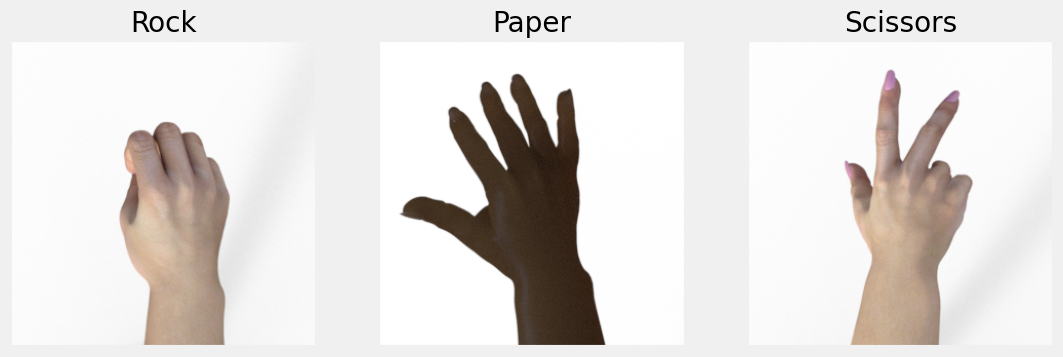

In [ ]:
#|code-fold: true
#|output: false
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from pytorched.step_by_step import StepByStep
import platform
from PIL import Image
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

from tqdm.autonotebook import tqdm

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

from torchvision.datasets import ImageFolder
from data_generation.rps import download_rps

plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#|code-fold: true 
def show_image(im, cmap=None):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(im, cmap=cmap)
    plt.grid(False)
    plt.show()

# Data

In [ ]:
#|code-fold: true 
#|output: false
download_rps()

rps folder already exists!
rps-test-set folder already exists!


## Temporary dataset

We need to calculate normalization parameters (mean and std) for all training images first. This is important step as we will use these normalization parameters not only for training images but for all the validation, and any future, predictions. Since we need to only calculate normalization parameters, we can also scale images to smaller size, just so the calculation is faster.

In [ ]:
composer = Compose([Resize(28), ToTensor()])
temp_dataset = ImageFolder(root='rps', transform=composer)
temp_loader = DataLoader(temp_dataset, batch_size=16)
normalizer = StepByStep.make_normalizer(temp_loader)
normalizer

Normalize(mean=tensor([0.8502, 0.8215, 0.8116]), std=tensor([0.2089, 0.2512, 0.2659]))

# Real dataset

In [ ]:
composer = Compose([Resize(28), ToTensor(), normalizer])
train_dataset = ImageFolder(root='rps', transform=composer)
val_dataset = ImageFolder(root='rps-test-set', transform=composer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [ ]:
images, labels = next(iter(train_loader))

In [ ]:
train_loader

<torch.utils.data.dataloader.DataLoader>

In [ ]:
labels

tensor([2, 1, 0, 2, 1, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 0])

# Deep model

We'll use `CrossEntropyLoss` (and not add `LogSoftmax` layer):

In [ ]:
class CNN2(nn.Module):
    def __init__(self, n_filters, p=0.3):
        super(CNN2, self).__init__()
        
        self.n_filters = n_filters
        self.p = p
        
        # conv1 takes (3,28,28) and outputs (n_filters,26,26)
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=n_filters, 
            kernel_size=3
        )
        
        # conv2 takes (n_filters,13,13) and outputs (n_filters,11,11)
        self.conv2 = nn.Conv2d(
            in_channels=n_filters, 
            out_channels=n_filters, 
            kernel_size=3
        )
        
        self.fc1 = nn.Linear(n_filters*5*5, 50)
        self.fc2 = nn.Linear(50,3)
        
        self.drop = nn.Dropout(p)
        
    def featurizer(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(kernel_size=2)(x)  # (n_filters,13,13)
        
        x = self.conv2(x)  # n_filters,11, 11 
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(kernel_size=2)(x)  # (n_filters,5,5)
        
        x = nn.Flatten()(x)
        return x
    
        
    def classifier(self, x):
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        x = nn.Flatten()(x)
        return x
        
    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x
    

In [ ]:
model_cnn = CNN2(5)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=3e-4)
multi_loss_fn = nn.CrossEntropyLoss()

In [ ]:
sbs = StepByStep(model_cnn, optimizer_cnn, multi_loss_fn)

In [ ]:
sbs = StepByStep(model_cnn, optimizer_cnn, multi_loss_fn)
# sbs.set_seed()
sbs.set_loaders(train_loader, val_loader)
sbs.train(10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:59<00:00, 11.91s/it]


In [ ]:
sbs.train(10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:57<00:00, 11.76s/it]


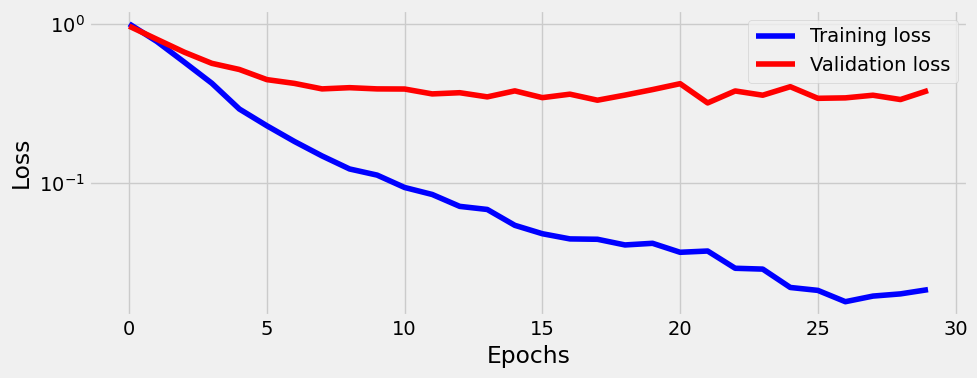

In [ ]:
fig = sbs.plot_losses()

In [ ]:
#|code-fold: true
print('Correct categories:')
print(sbs.loader_apply(sbs.val_loader, sbs.correct))

Correct categories:
tensor([[117, 124],
        [ 93, 124],
        [101, 124]])


In [ ]:
#|code-fold: true 
print(f'Accuracy: {sbs.accuracy}%')

Accuracy: 83.6%


It was 85% after 20 epoch and 83.6% after 30. Not too bad.

# Visualize filters

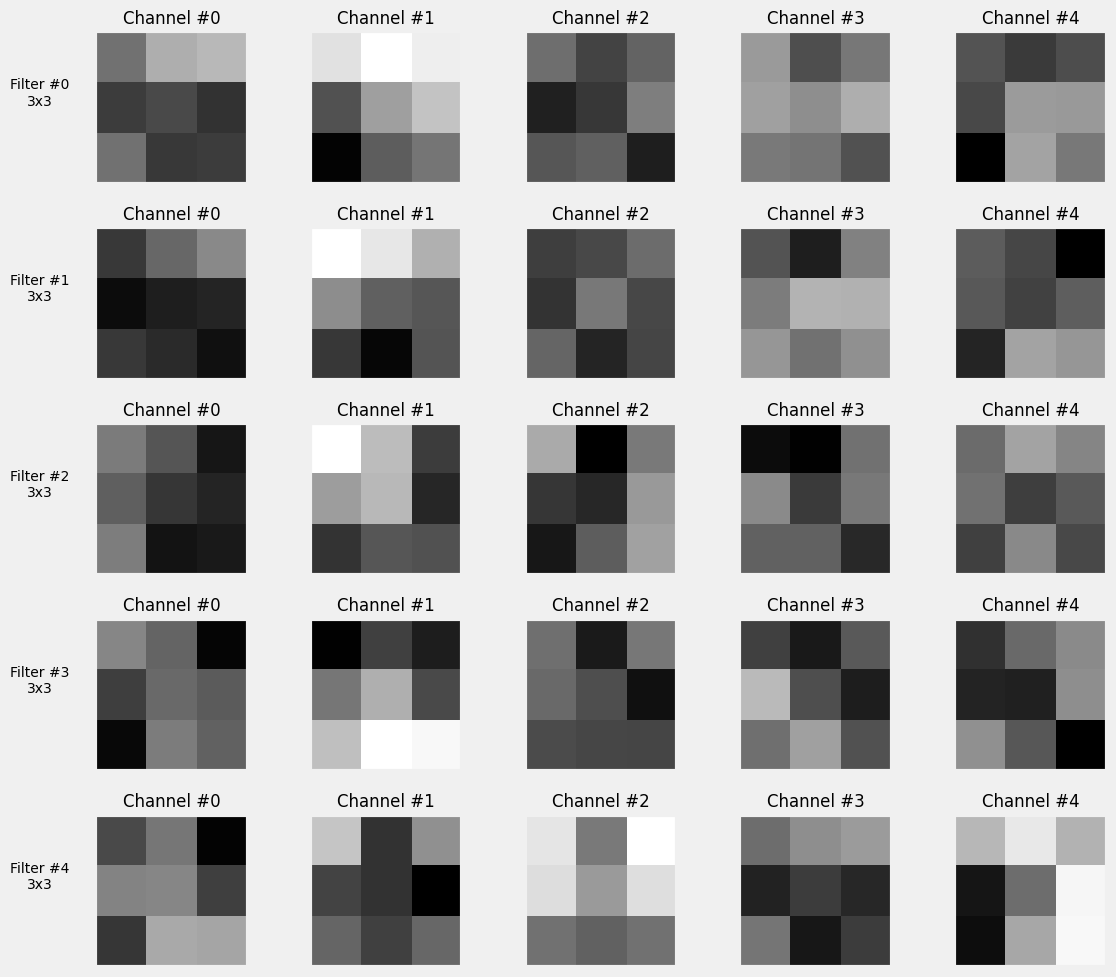

In [ ]:
fig_filters = sbs.visualize_filters('conv2', cmap='gray')

Not too informative.

# Off the shelf LRFinder

In [ ]:
from torch_lr_finder import LRFinder

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.02E-03


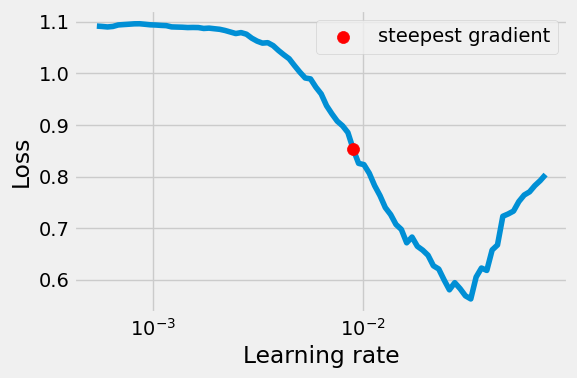

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

torch.manual_seed(11)
new_model = CNN2(5, 0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=3e-4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

lr_finder = LRFinder(new_model, new_optimizer, multi_loss_fn, device=device)
lr_finder.range_test(train_loader, end_lr=1e-1, num_iter=100)
lr_finder.plot(ax=ax, log_lr=True)

fig.tight_layout()
lr_finder.reset()

# Custom Learning Rate finder

For this we'll use `torch.optim.lr_scheduler` with make options: `StepLR`, `ReduceLROnPlateau`,
`MultiStepLR`, `CyclicLR`, `LambdaLR`. They all work by steping through iterations of learning rates, using `step` method (similar to optimizer `step`).

We first define a function that can make linear or exponential scalling factors between `start_lr` and `end_lr`:

In [ ]:
def make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp'):
    if step_mode == 'linear':
        factor = (end_lr / start_lr - 1) / num_iter
        def lr_fn(iteration):
            return 1 + iteration * factor
    else:
        factor = (np.log(end_lr) - np.log(start_lr)) / num_iter    
        def lr_fn(iteration):
            return np.exp(factor)**iteration    
    return lr_fn

If we now make optimizer and scheduler, we can step through and see that learning late changes with each step:

In [ ]:
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.01)
scheduler = LambdaLR(optimizer_cnn, lr_lambda=make_lr_fn(0.01, 0.1, 10))

In [ ]:
for _ in range(3):
    print(scheduler.get_last_lr())
    optimizer_cnn.step()
    scheduler.step()

[0.01]
[0.012589254117941673]
[0.015848931924611138]


We can make a `lr_range_test` method, and use it to plot the loss for differetn learning rates:

In [ ]:
model_cnn = CNN2(5)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=3e-4)
multi_loss_fn = nn.CrossEntropyLoss()

In [ ]:
sbs = StepByStep(model_cnn, optimizer_cnn, multi_loss_fn)

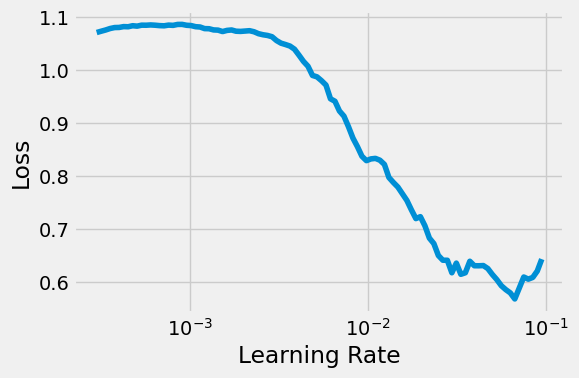

In [ ]:
tracking, fig = sbs.lr_range_test(train_loader, end_lr=1e-1, num_iter=100)